Initial data pipeline
=====================
Pipeline to select first set of training data.

Only intended to be used once or twice, I'm so sticking this in a Notebook rather than in a module. I intend to sample new data in a smarter way once an initial model is in place (active learning).

## Approach
- Crop data to ROI rectangle.
- Use Locality Sensitive Hashing (LSH) to reject duplicates / promote heterogeniety.
- Write out files that seem (sufficiently) unique, as cropped rectangle. Use the same folder structure.

After this, I'll need to manually label the frames as either `BirdHome` (in or on cage) and `BirdRoaming` (bird seems to be elsewhere). 

In [71]:
from collections import defaultdict
from pathlib import Path
import random
from math import ceil
from itertools import zip_longest
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import cv2
import matplotlib.pyplot as plt

from pipeline_helper import (img_roi_hash, apply_roi, ROI_X_MAX, ROI_X_MIN, ROI_Y_MAX, ROI_Y_MIN)

In [2]:
BASE_PATH = Path("~/tmp/Birdcam-data").expanduser()
all_img_paths = sorted(BASE_PATH.glob("raw/*/*.jpeg"))
len(all_img_paths)

20876

In [64]:
plot_n_cols = 6
sample_k = 12

sample_img_paths = random.choices(all_img_paths, k=sample_k)

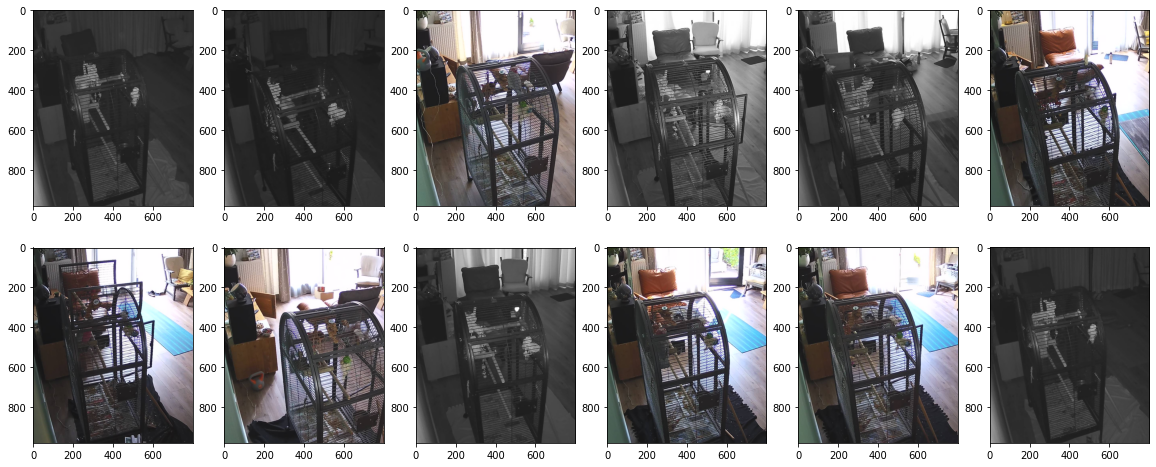

In [65]:
nrows = sample_k // plot_n_cols
_, axes = plt.subplots(ncols=plot_n_cols, nrows=nrows,
                       figsize=(20, nrows * 4))

for img_path, ax in zip(sample_img_paths, axes.ravel()):
    img = cv2.imread(str(img_path))
    img_crop = apply_roi(img)
    img_crop_rgb = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_crop_rgb)

plt.show()

In [44]:
%%time

with ProcessPoolExecutor(max_workers=15) as exc:
    hashes = exc.map(img_roi_hash, all_img_paths)
    
hash_files = defaultdict(list)

for hsh, img_path in zip(hashes, all_img_paths):
    hash_files[hsh].append(img_path)
    
print(f"{len(hash_files)} remaining, reduction: {100 * (len(hash_files) - len(all_img_paths)) / len(all_img_paths):.1f} %")

12052 remaining, reduction: -42.3 %
CPU times: user 10 s, sys: 2 s, total: 12 s
Wall time: 3min 29s


Let's look at the hashes with the most duplications and see if this makes sense.

In [61]:
most_dupe = sorted(hash_files.items(), key=lambda x: len(x[1]))[-3:]

In [62]:
for hsh, lst in most_dupe:
    print(f"{hsh}: {len(lst)}")

1540c68cb05382c286945c82c65632143065138c1ce: 135
05a8cb061a1b48a645886c626251c6463373890c6d6: 152
0dc1c706381880fa07945cd266930e0cb27103985a4: 228


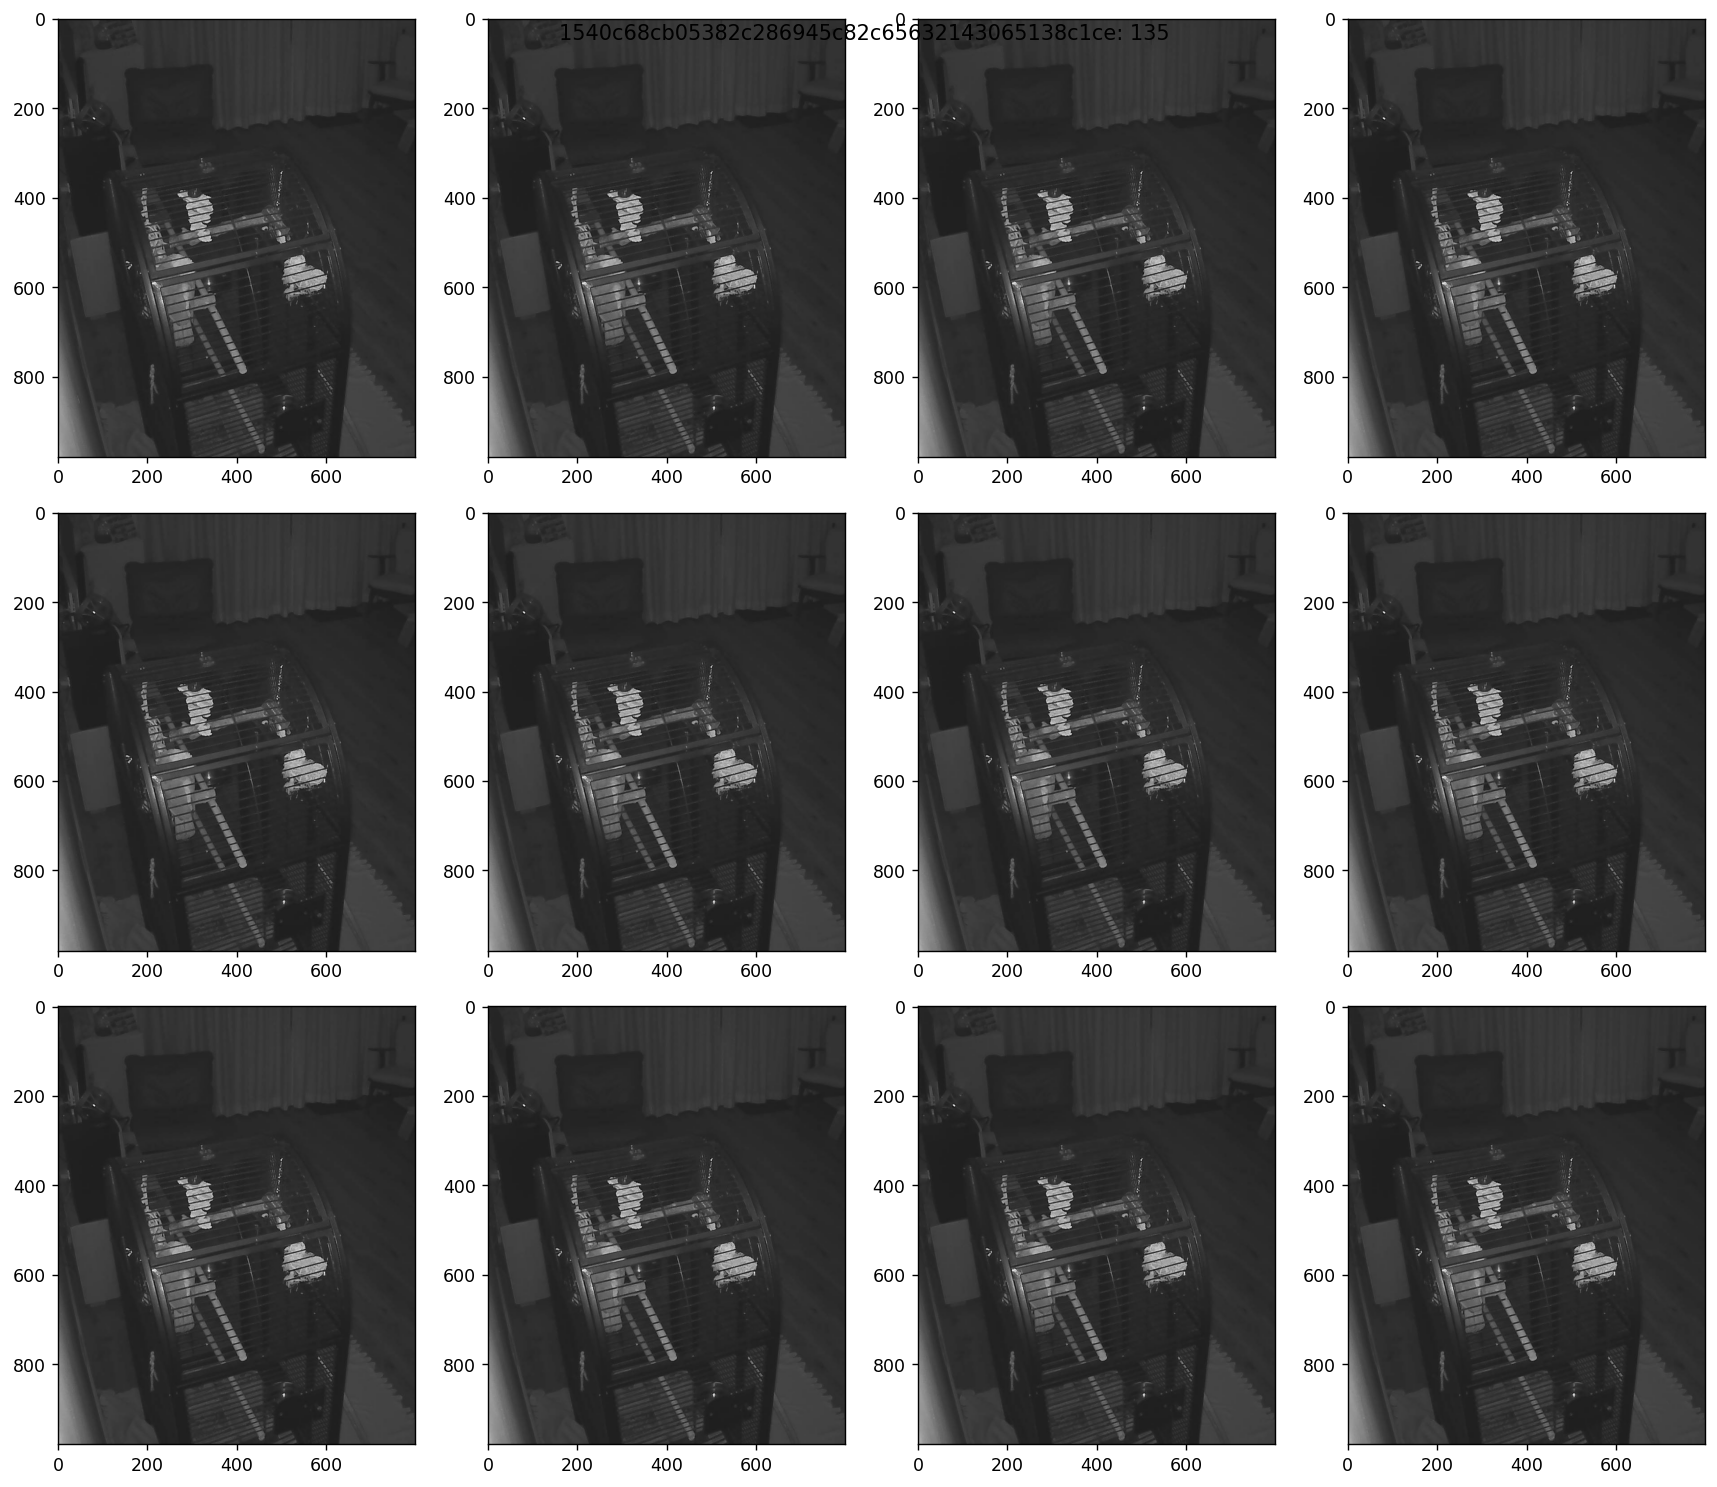

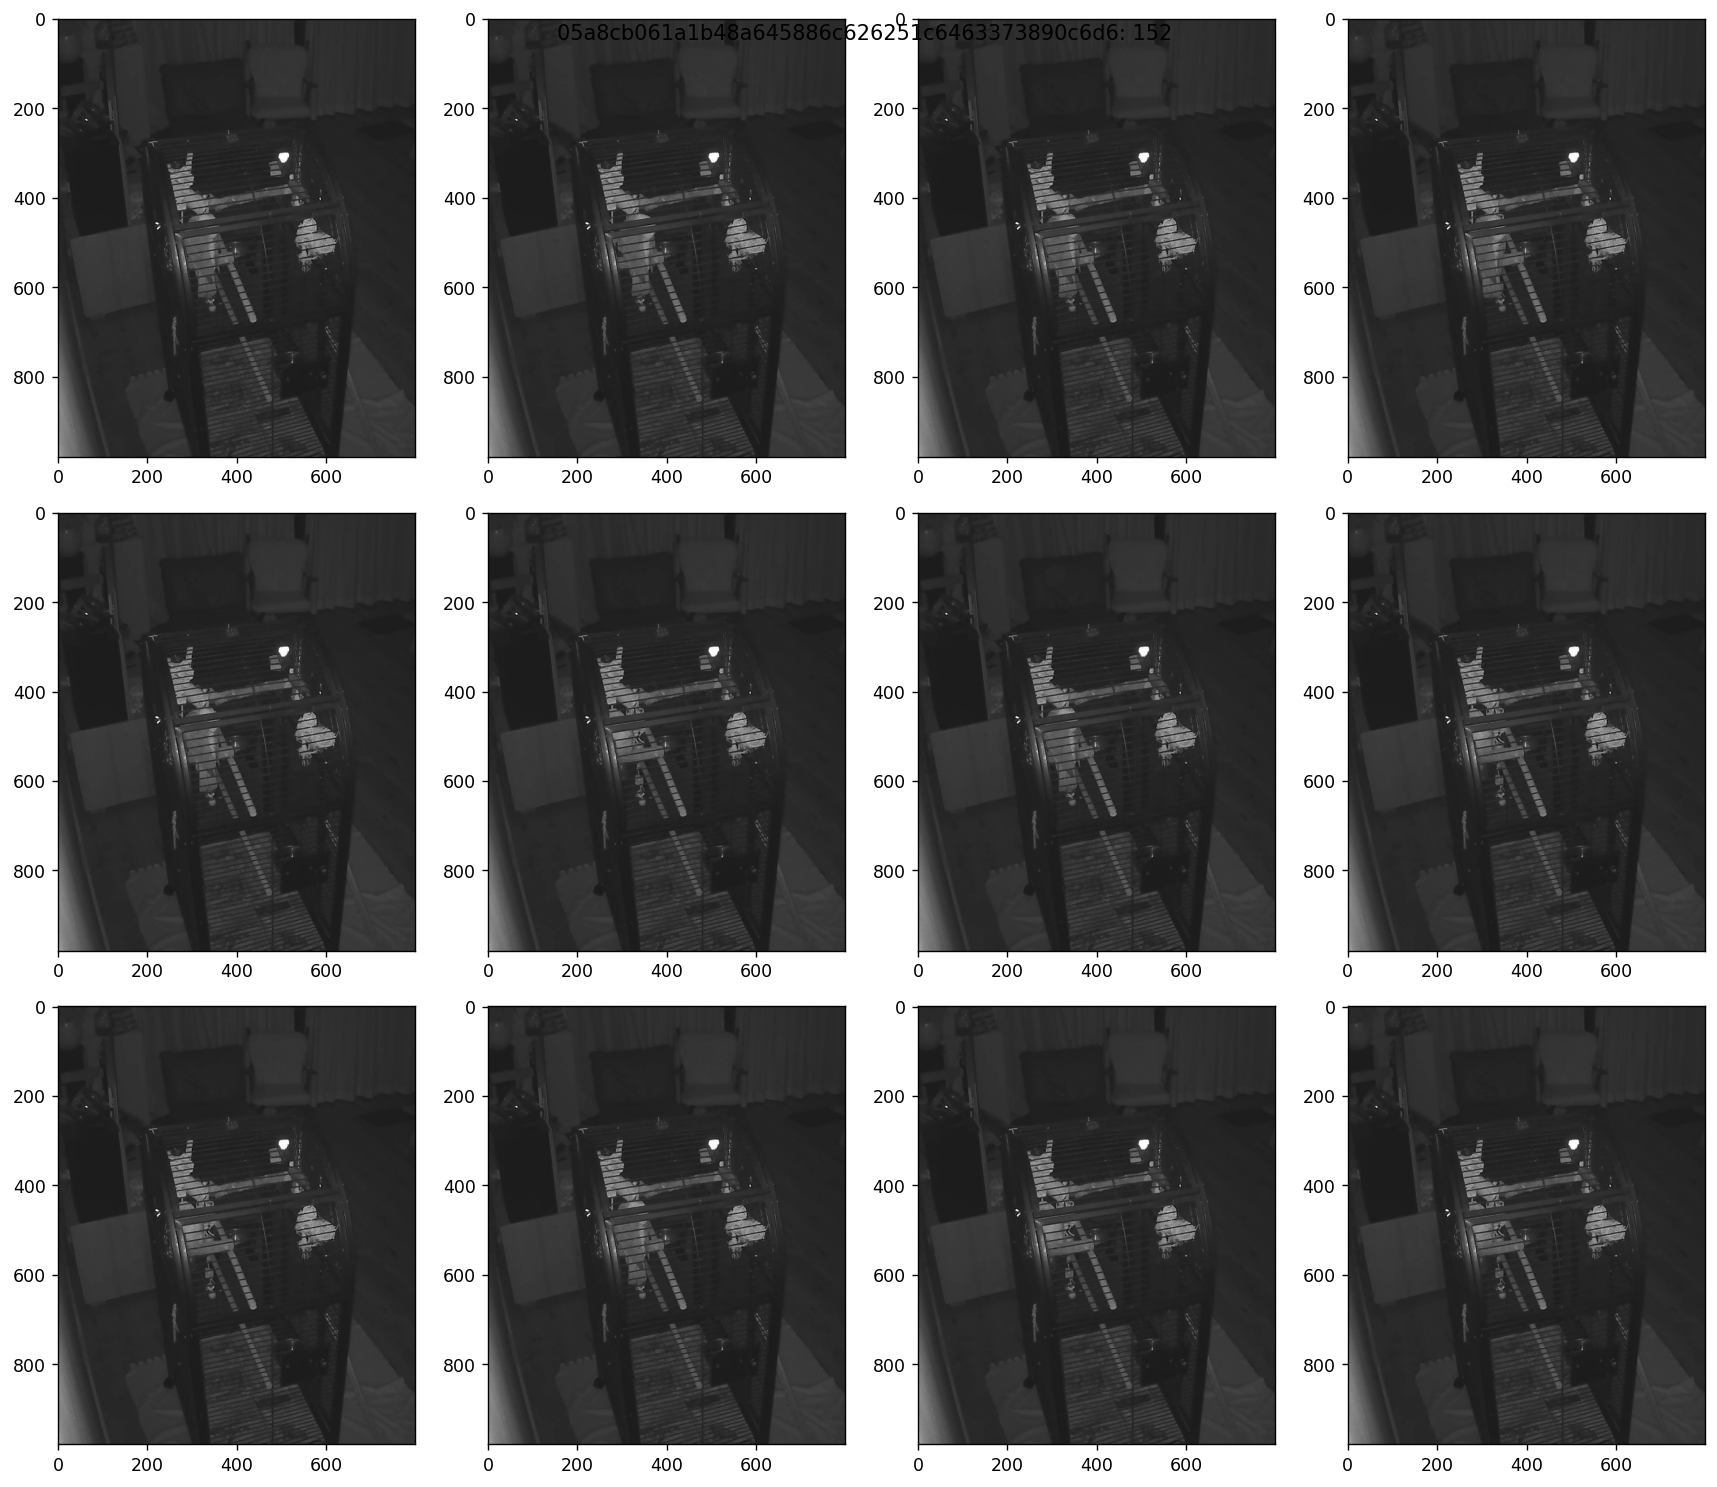

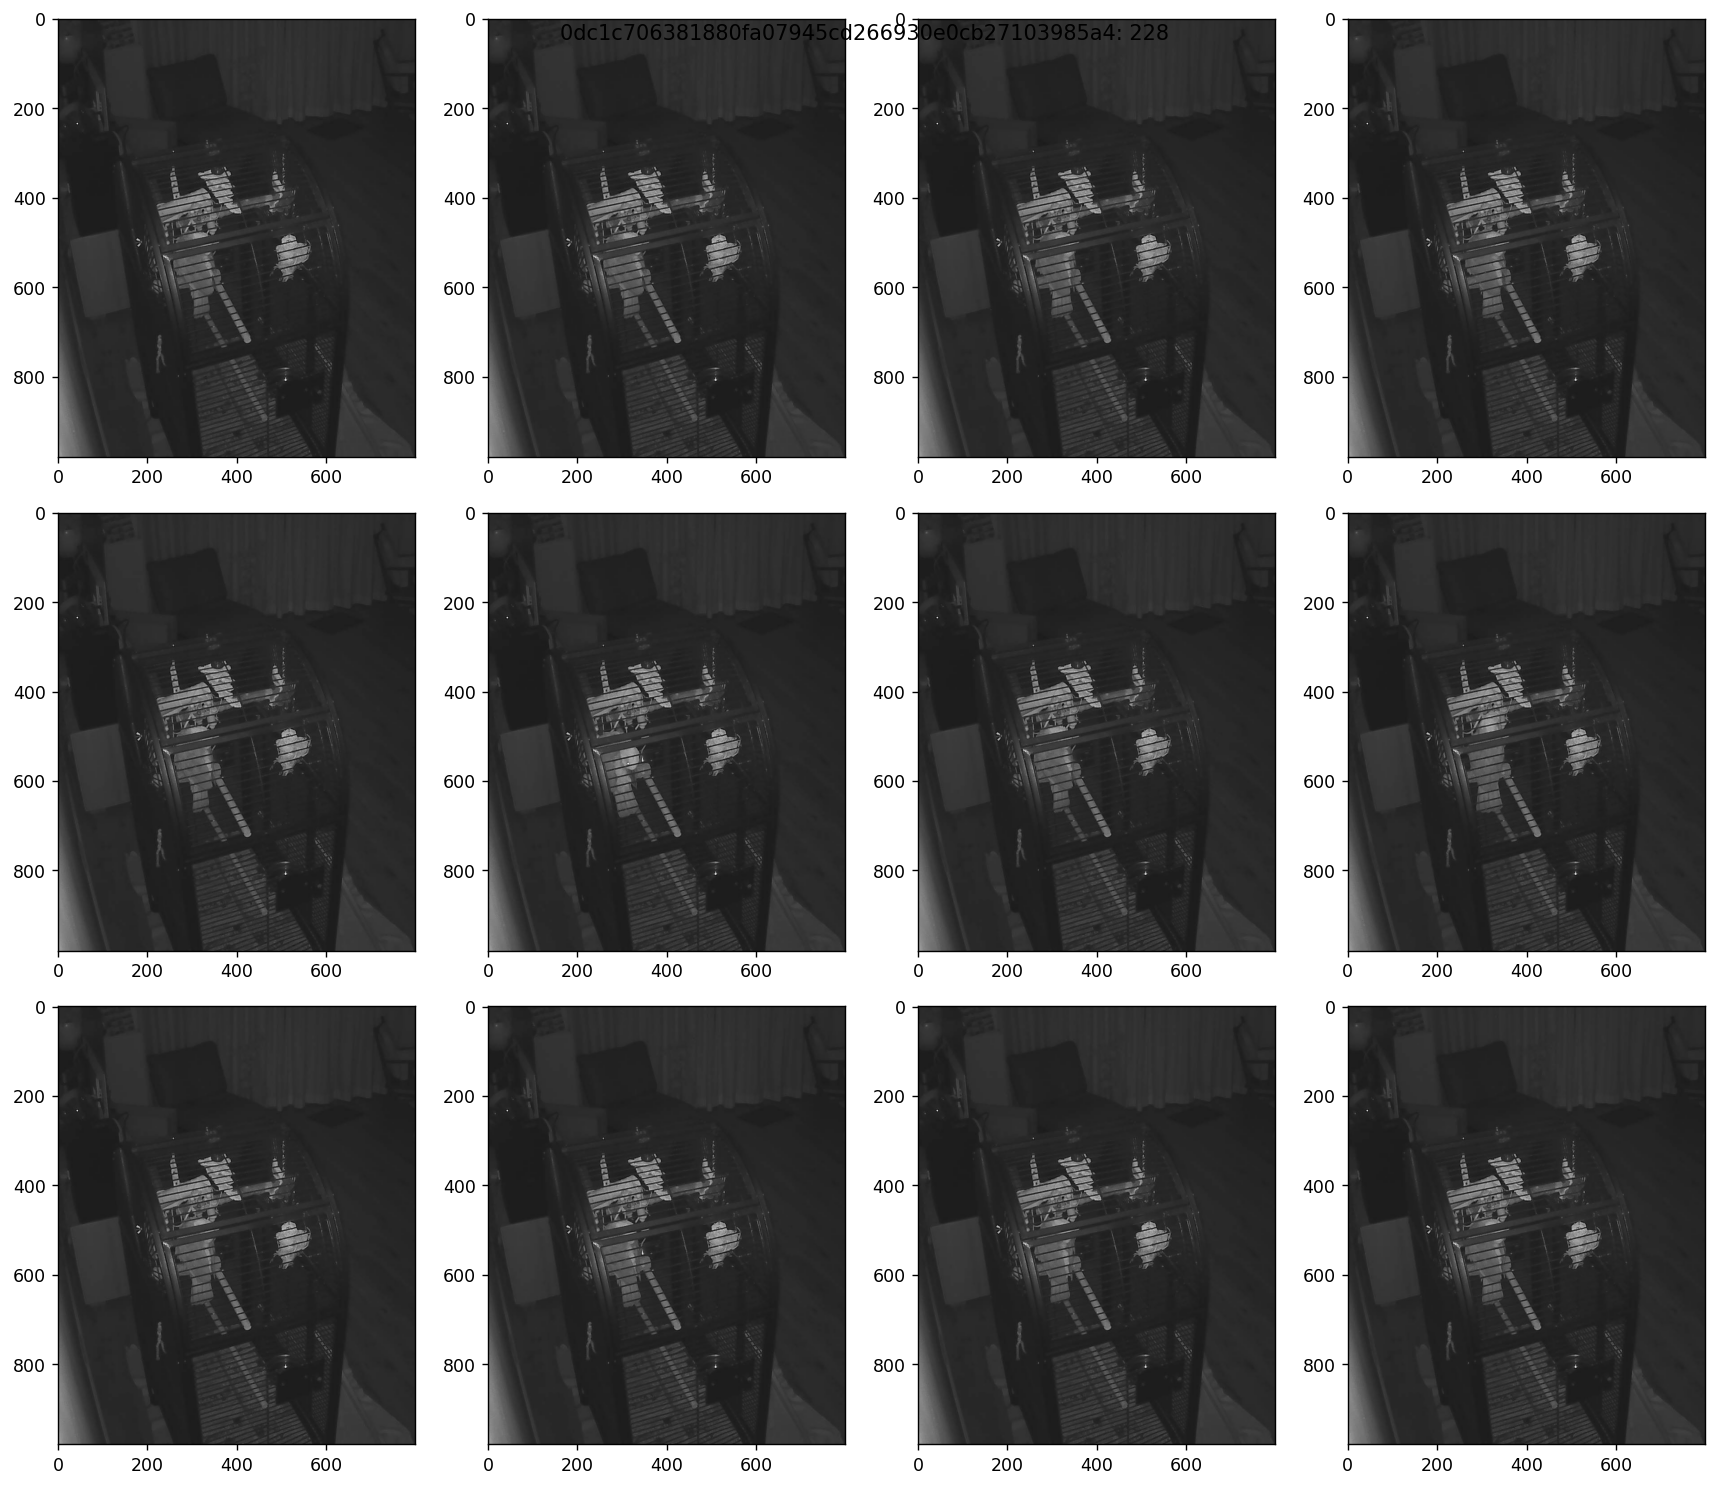

In [63]:
for hsh, files in most_dupe:
    files_sample = random.choices(files, k=12)
    
    ncols = 4
    nrows = ceil(len(files_sample) / ncols)
    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, nrows * 4), dpi=125)

    for img_path, ax in zip_longest(files_sample, axes.ravel()):
        if not img_path:
            ax.axis("off")
        else:
            ax.imshow(apply_roi(plt.imread(img_path)))
            
    plt.suptitle(f"{hsh}: {len(files)}")
    plt.tight_layout()
    plt.show()

This makes sense, mostly images of a sleeping bird in the same pose. Very similar images in 1 cluster. It's not perfect, but that's ok, this technique is pretty simple after all.

Ran this for a couple times to try different hash sizes and checked out the top 30 as well. Eventually settled on hash size of 13. Reduced to top 3 to save notebook with less data.

## Write cropped de-duplicated images

In [76]:
DEST = BASE_PATH / "cropped-unique"
if DEST.exists():
    print(f"{DEST} already exists; cowardly quitting!")
    raise FileExistsError
else:
    DEST.mkdir()
    

for img_paths in hash_files.values():
    if len(img_paths) > 1:
        path = random.choice(img_paths)
    else:
        path = img_paths[0]
        
    dest_path = Path(str(path).replace("raw", "cropped-unique"))
    if not dest_path.parent.is_dir():
        dest_path.parent.mkdir()
        
    img = apply_roi(cv2.imread(str(path)))
    cv2.imwrite(str(dest_path), img, [cv2.IMWRITE_JPEG_QUALITY, 80])